# Version 2 #
# Target:
#### Improve model by updating last convolution layer with a **Global Average Pooling (GAP)** layer.
### Results:

* Parameters: 5,733
* Best Train Accuracy: 98.46%
* Best Test Accuracy: 98.45%

**Analysis:**
<br> Model is having parameters less than 8000 parameters.
<br> GAP helped to reduce the number of parameters.
<br> Overfitting is reduced now.
<br> Network capacity is reduced and it is expected that reduction in model accuracies.


In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations



In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.47MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.94MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Dataloader Arguments & Test/Train Dataloaders



In [5]:
SEED = 1

cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)


CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# The Model Architecture


In [22]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=7, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 26x26 (28x28 input - 3x3 kernel + 1)

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 24x24 (26x26 input - 3x3 kernel + 1)

        # First pooling layer (removed duplicate definition)
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12x12 (24x24 input / 2)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=7, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 10x10 (12x12 input - 3x3 kernel + 1)

        # TRANSITION BLOCK 1
        # Note: pool1 is already defined above, removed duplicate
        # After pooling: output_size = 5x5 (10x10 input / 2)

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=7, out_channels=14, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 5x5 (1x1 kernel maintains size)

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=28, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 3x3 (5x5 input - 3x3 kernel + 1)

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=28, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU()
        ) # output_size = 3x3 (1x1 kernel maintains size)

        self.convblock7 = nn.Sequential(
            nn.AvgPool2d(kernel_size=3)
        ) # output_size = 1x1 (3x3 input pooled over 3x3 kernel)

    def forward(self, x):
        x = self.convblock1(x)  # 28x28 -> 26x26
        x = self.convblock2(x)  # 26x26 -> 24x24
        x = self.pool1(x)       # 24x24 -> 12x12
        x = self.convblock3(x)  # 12x12 -> 10x10
        x = self.pool1(x)       # 10x10 -> 5x5
        x = self.convblock4(x)  # 5x5 -> 5x5 (maintained)
        x = self.convblock5(x)  # 5x5 -> 3x3
        x = self.convblock6(x)  # 3x3 -> 3x3 (maintained)
        x = self.convblock7(x)  # 3x3 -> 1x1
        x = x.view(-1, 10)      # Flatten to (batch_size, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [23]:
!pip install torchsummary

In [24]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              63
              ReLU-2            [-1, 7, 26, 26]               0
            Conv2d-3           [-1, 14, 24, 24]             882
              ReLU-4           [-1, 14, 24, 24]               0
         MaxPool2d-5           [-1, 14, 12, 12]               0
            Conv2d-6            [-1, 7, 10, 10]             882
              ReLU-7            [-1, 7, 10, 10]               0
         MaxPool2d-8              [-1, 7, 5, 5]               0
            Conv2d-9             [-1, 14, 5, 5]              98
             ReLU-10             [-1, 14, 5, 5]               0
           Conv2d-11             [-1, 28, 3, 3]           3,528
             ReLU-12             [-1, 28, 3, 3]               0
           Conv2d-13             [-1, 10, 3, 3]             280
             ReLU-14             [

# Training and Testing

In [13]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model


In [14]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Loss=2.0064549446105957 Batch_id=468 Accuracy=14.48: 100%|██████████| 469/469 [00:36<00:00, 12.94it/s]



Test set: Average loss: 1.8369, Accuracy: 4037/10000 (40.37%)

EPOCH: 1


Loss=0.7540363669395447 Batch_id=468 Accuracy=58.94: 100%|██████████| 469/469 [00:32<00:00, 14.25it/s]



Test set: Average loss: 0.8640, Accuracy: 7148/10000 (71.48%)

EPOCH: 2


Loss=0.157623752951622 Batch_id=468 Accuracy=83.69: 100%|██████████| 469/469 [00:31<00:00, 14.84it/s]



Test set: Average loss: 0.2570, Accuracy: 9168/10000 (91.68%)

EPOCH: 3


Loss=0.24026013910770416 Batch_id=468 Accuracy=94.17: 100%|██████████| 469/469 [00:31<00:00, 15.02it/s]



Test set: Average loss: 0.1483, Accuracy: 9544/10000 (95.44%)

EPOCH: 4


Loss=0.14149175584316254 Batch_id=468 Accuracy=95.90: 100%|██████████| 469/469 [00:30<00:00, 15.14it/s]



Test set: Average loss: 0.1036, Accuracy: 9669/10000 (96.69%)

EPOCH: 5


Loss=0.24970726668834686 Batch_id=468 Accuracy=96.54: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s]



Test set: Average loss: 0.1045, Accuracy: 9679/10000 (96.79%)

EPOCH: 6


Loss=0.14101490378379822 Batch_id=468 Accuracy=97.08: 100%|██████████| 469/469 [00:30<00:00, 15.21it/s]



Test set: Average loss: 0.0833, Accuracy: 9737/10000 (97.37%)

EPOCH: 7


Loss=0.13937316834926605 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:32<00:00, 14.47it/s]



Test set: Average loss: 0.0682, Accuracy: 9793/10000 (97.93%)

EPOCH: 8


Loss=0.06043247506022453 Batch_id=468 Accuracy=97.70: 100%|██████████| 469/469 [00:34<00:00, 13.64it/s]



Test set: Average loss: 0.0680, Accuracy: 9791/10000 (97.91%)

EPOCH: 9


Loss=0.13470983505249023 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:31<00:00, 14.98it/s]



Test set: Average loss: 0.0549, Accuracy: 9840/10000 (98.40%)

EPOCH: 10


Loss=0.051369983702898026 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:31<00:00, 14.91it/s]



Test set: Average loss: 0.0570, Accuracy: 9831/10000 (98.31%)

EPOCH: 11


Loss=0.03246081992983818 Batch_id=468 Accuracy=98.25: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]



Test set: Average loss: 0.0515, Accuracy: 9839/10000 (98.39%)

EPOCH: 12


Loss=0.11007019877433777 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:31<00:00, 15.13it/s]



Test set: Average loss: 0.0493, Accuracy: 9839/10000 (98.39%)

EPOCH: 13


Loss=0.037374723702669144 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:31<00:00, 15.01it/s]



Test set: Average loss: 0.0609, Accuracy: 9818/10000 (98.18%)

EPOCH: 14


Loss=0.01924811489880085 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s]



Test set: Average loss: 0.0471, Accuracy: 9845/10000 (98.45%)



Text(0.5, 1.0, 'Test Accuracy')

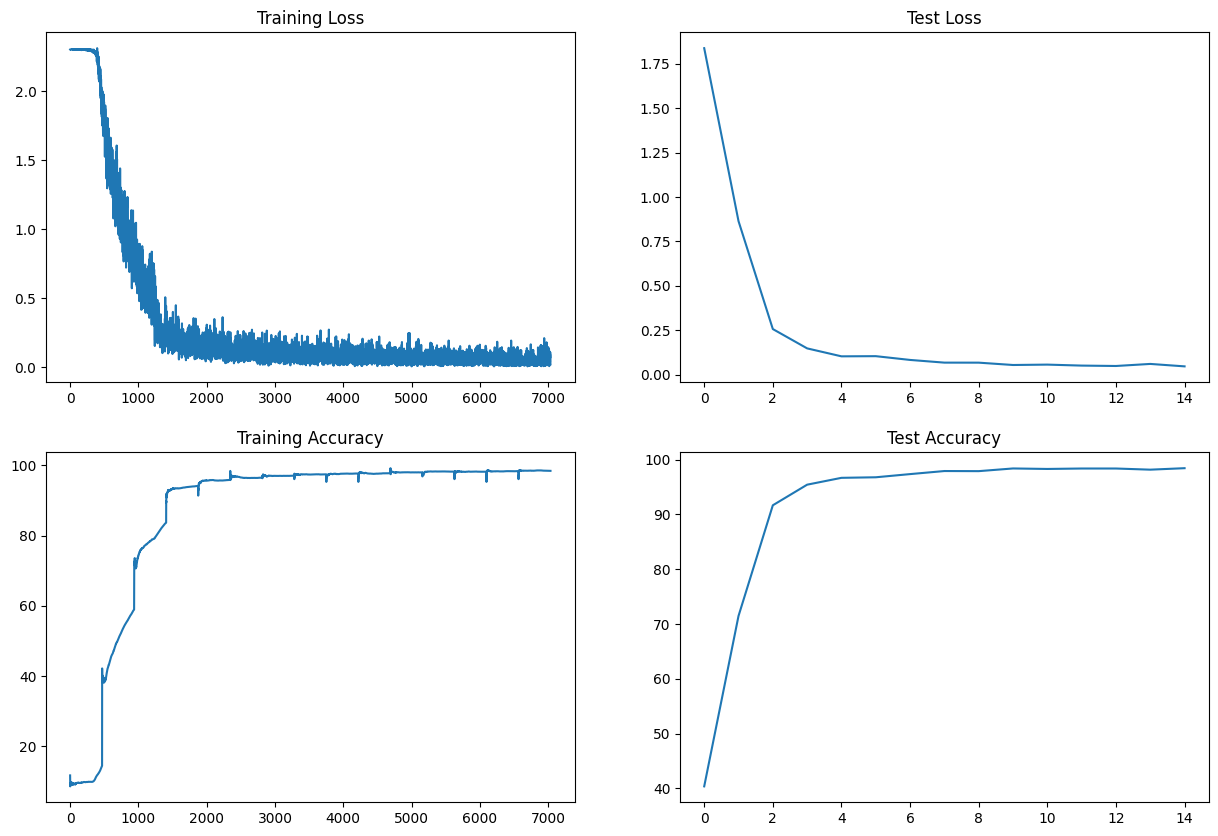

In [15]:
# Commented out IPython magic to ensure Python compatibility.
t = [t_items.item() for t_items in train_losses]
# %matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")